# Web Scraping for Indeed.com & Predicting Salaries

### Scraping job listings from Indeed.com

In [2]:
import requests
import bs4
from bs4 import BeautifulSoup
import sys
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn import svm
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import cross_val_score, cross_val_predict, train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
url = "http://www.indeed.com/jobs?q=data+scientist&l=New+York%2C+NY&start=1"

In [ ]:
# try out scraping function on a single page to see if it scrapes the right contents successfully

response = requests.get(url)
soup = BeautifulSoup(response.content)
jobs=[]
for post in soup.find_all('div', {'class':' row result'}):
    job={}
    job['title'] = post.find('a').get('title')
    try:
        job['company'] = post.find('span', {'itemprop':'name'}).getText()
    except:
        job['company'] = None
    job['location'] = post.find('span', {'class':'location'}).getText()
    job['summary'] = post.find('span', {'class':'summary'}).getText()
    try:
        job['salary'] = post.find('td', {'class':'snip'}).find('nobr').renderContents()
    except:
        job['salary'] = None
    jobs.append(job)
jobs

In [ ]:
# try to convert contents into dataframe to take a look

test = pd.DataFrame(jobs)
test

In [ ]:
# create a function to automatically go through pages and scrape results for more cities

url_template = "http://www.indeed.com/jobs?q=data+scientist+%2420%2C000&l={}&start={}"
max_results_per_city = 5000 # Set this to a high-value (5000) to generate more results. 

results = []

for city in set(['New+York', 'Chicago', 'San+Francisco', 'Austin', 'Seattle', 
    'Los+Angeles', 'Philadelphia', 'Atlanta', 'Dallas', 'Pittsburgh', 
    'Portland', 'Phoenix', 'Denver', 'Houston', 'Miami', 'Virginia']):
    for start in range(0, max_results_per_city, 10):
        # Grab the results from the request (as above)
        r = requests.get(url_template.format(city, start))
        soup = BeautifulSoup(r.content)
        for post in soup.find_all('div', {'class':' row result'}):
            result={}
            try:
                result['company'] = post.find('span', {'itemprop':'name'}).getText()
            except:
                result['company'] = None
            result['title'] = post.find('a').get('title')
            result['location'] = post.find('span', {'class':'location'}).getText()
            result['summary'] = post.find('span', {'class':'summary'}).getText()
            try:
                result['salary'] = post.find('td', {'class':'snip'}).find('nobr').renderContents()
            except:
                result['salary'] = None
            results.append(result)
       

In [ ]:
# convert results to dataframe
df = pd.DataFrame(results)

In [ ]:
# save raw data to a file

reload(sys)
sys.setdefaultencoding('utf-8')
df.to_csv('~/desktop/dsjobs.csv')

In [ ]:
# Find the entries with annual salary entries, 
# by filtering the entries without salaries or salaries that are not yearly 
#(filter those that refer to hour or week). Also, remove duplicate entries

df.dropna(inplace=True)
df.drop_duplicates(inplace=True)
df = df[df.salary.str.contains('hour')==False]
df = df[df.salary.str.contains('week')==False]
df = df[df.salary.str.contains('month')==False]
df = df[df.salary.str.contains('day')==False]

In [ ]:
# clean strings
df.summary = df.summary.apply(lambda x: x.strip())
df.company = df.company.apply(lambda x: x.strip())

In [ ]:
# Convert salary string to number, and average a salary range

df.salary = df.salary.apply(lambda x: x.replace(' a year', ''))
df.salary = df.salary.apply(lambda x: x.replace('$', ''))
df.salary = df.salary.apply(lambda x: x.replace(',', ''))

In [ ]:
def number(x):
    if '-' in x:
        return (int(x.split('-')[0])+int(x.split('-')[1]))/2
    else:
        return int(x)
df.salary = df.salary.apply(number)

### Save cleaned data as a CSV

In [ ]:
# Save data to csv file to do more EDA with Tableau
df.to_csv('cleandata.csv')

## EDA and Feature Engineering

In [3]:
data = pd.read_csv('cleandata.csv')
data.drop('Unnamed: 0', axis=1, inplace=True)

In [4]:
# create binary dependent variable

data['high_salary'] = data.salary.apply(lambda x: 0 if x<np.median(data.salary) else 1)
data.rename(columns={'company': 'employer'}, inplace=True)

In [5]:
# check the benchmark

float(data.high_salary.sum())/len(data.high_salary)

0.5017064846416383

In [6]:
# uniform location to city level

def place(x):
    return x.split(',')[0] + ', ' + x.split(',')[1][0:3]
data.location = data.location.apply(place)

In [7]:
# label categorical feature

le = LabelEncoder()
data['location_num'] = le.fit_transform(data.location)

In [8]:
# create a categorical feature from 'title' to identify the hierachy of titles

def position(x):
    if 'Manager' in x:
        return 3
    elif 'Principal' in x:
        return 2
    elif 'Senior' in x:
        return 1
    else:
        return 0
data['high_position'] = data.title.apply(position)

### Conduct natural language processing on summary to create text features

In [9]:
# Create text matrix. Use Tfidf instead of Countvectorizer to create standardized text features.

tvec = TfidfVectorizer(stop_words='english')
tvec.fit(data.summary)
words = pd.DataFrame(tvec.transform(data.summary).todense(), columns = tvec.get_feature_names())

In [10]:
# merge text matrix back to the main dataframe

df = pd.concat([data, words], axis=1)

In [11]:
df.head()

,employer,location,salary,summary,title,high_salary,location_num,high_position,000,10,...,world,write,writing,written,xor,xrd,yearly,years,york,zachary
0,Avispa Technology,"Houston, TX",100000,Works with multi-functional teams focused on e...,Data Scientist 5796057,0,28,0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,DISYS,"Houston, TX",135000,Works with multi-functional teams focused on e...,Principal Data Scientist,1,28,2,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Baylor College of Medicine,"Houston, TX",60998,External Title: Senior Quality Assurance / Qua...,Senior Quality Assurance / Quality Control (Re...,0,28,1,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Oscar Technology,"Houston, TX",160000,Work with data scientist to identify data need...,Big Data Analytics Manager,1,28,3,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Baylor College of Medicine,"Houston, TX",72120,Uses and customizes statistical graphing tools...,Bioinformatics Programmer II,0,28,0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Feature Selection

In [12]:
# utilize random forest to select features.
# Idealy, I should do train test split and conduct feature selection and model optimization only on training set,
# However, as the data is too small, doing train test split will dramatically affect model performance.
# So here I only did cross validation in order to make use of the whole dataset

rf = RandomForestClassifier(n_jobs=-1)

X = df.iloc[:,6:]
y = df.high_salary

rf.fit(X, y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=-1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

In [13]:
feature_importances = pd.DataFrame(rf.feature_importances_,
                                   index = X.columns,
                                    columns=['importance']).sort_values('importance',
                                                                        ascending=False)
feature_importances.head(20)

,importance
data,0.069475
analytics,0.046889
team,0.032315
big,0.026158
location_num,0.024852
scientists,0.023610
scientist,0.022645
python,0.015266
high_position,0.013530
learning,0.012604


In [14]:
X = df[['location_num', 'high_position', 'data', 'analytics', 'team', 'big', 'scientists', 'scientist', 'python', 
       'learning', 'derivative', 'client']]

### Define functions to fit, optimize and evaluate models

In [15]:
# Difine function to optimize parameters with grid search

def gridsearch(model, params):
    gs = GridSearchCV(model, params, n_jobs=-1)
    gs.fit(X, y)
    print 'Best parameters: ', gs.best_params_
    print 'Best score: ', gs.best_score_

In [24]:
# Define function to evaluate models

def evaluation(model):
    print 'Mean cross validation score: ', cross_val_score(model, X, y, n_jobs=-1).mean()
    return cross_val_predict(model, X, y, n_jobs=-1), cross_val_predict(model, X, y, method='predict_proba', n_jobs=-1)[:,1]

In [17]:
# Define function to print confusion matrix

def confusions(y_pred):
    conmat = np.array(confusion_matrix(y, y_pred, labels=[1,0]))
    confusion = pd.DataFrame(conmat, index=['high', 'low'], columns=['pred high', 'pred low'])
    print confusion

In [18]:
# Define function to plot ROC curve

def plot_roc(y_prob):
    fpr = dict()
    tpr = dict()
    roc_auc=dict()
    fpr[1], tpr[1], _ = roc_curve(y, y_prob)
    roc_auc[1] = auc(fpr[1], tpr[1])
    
    plt.figure(figsize=[11,9])
    plt.plot(fpr[1], tpr[1], label='ROC curve (area = %0.2f)' % roc_auc[1], linewidth=4)
    plt.plot([0, 1], [0, 1], 'k--', linewidth=4)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate', fontsize=18)
    plt.ylabel('True Positive Rate', fontsize=18)
    plt.title('Receiver operating characteristic for high salary', fontsize=18)
    plt.legend(loc="lower right")
    plt.show()

### Random Forest

In [19]:
# utilize grid search to optimize parameters

rf_params = {'n_estimators': [5,10,15,20], 'criterion': ['gini', 'entropy'], 
             'max_features': ['auto', 'sqrt', 'log2', None], 'max_depth': [3,5,10,None]}

gridsearch(rf, rf_params)

Best parameters:  {'max_features': 'log2', 'n_estimators': 5, 'criterion': 'gini', 'max_depth': 5}
Best score:  0.726962457338


In [25]:
# evaluate model performance by cross validation

rf = RandomForestClassifier(max_features='log2', n_estimators=5, criterion='gini', max_depth=5, n_jobs=-1)
rf_pred, rf_prob = evaluation(rf)

Mean cross validation score:  0.699523108212


In [26]:
# print confusion matrix

confusions(rf_pred)

      pred high  pred low
high         89        58
low          30       116


In [27]:
# print classification report

print classification_report(y, rf_pred)

             precision    recall  f1-score   support

          0       0.67      0.79      0.72       146
          1       0.75      0.61      0.67       147

avg / total       0.71      0.70      0.70       293



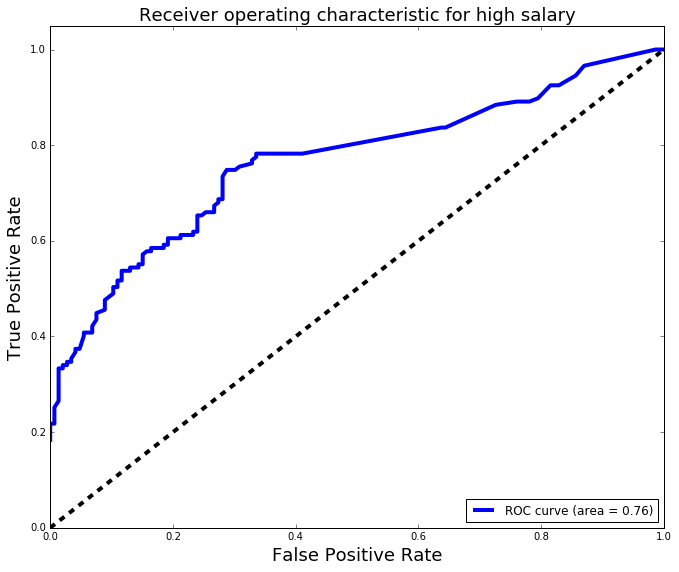

In [28]:
# plot the roc curve and calculate auc
# since I used random forest to do feature selection, there is probably overfitting here

plot_roc(rf_prob)

### Gradient Boosting

In [29]:
# try to use boosting to see if the accuracy score improve

gbc = GradientBoostingClassifier()
gbc_params = {'n_estimators': [100, 200, 250, 300], 'max_features': ['auto', 'sqrt', 'log2', None], 
              'max_depth': [3,5,10,None]}

gridsearch(gbc, gbc_params)

Best parameters:  {'max_features': 'sqrt', 'n_estimators': 100, 'max_depth': 3}
Best score:  0.713310580205


In [31]:
gbc = GradientBoostingClassifier(max_features='sqrt', n_estimators=100, max_depth=3)
gbc_pred, gbc_prob = evaluation(gbc)

Mean cross validation score:  0.720211796059


In [32]:
confusions(gbc_pred)

      pred high  pred low
high         95        52
low          30       116


In [33]:
print classification_report(y, gbc_pred)

             precision    recall  f1-score   support

          0       0.69      0.79      0.74       146
          1       0.76      0.65      0.70       147

avg / total       0.73      0.72      0.72       293



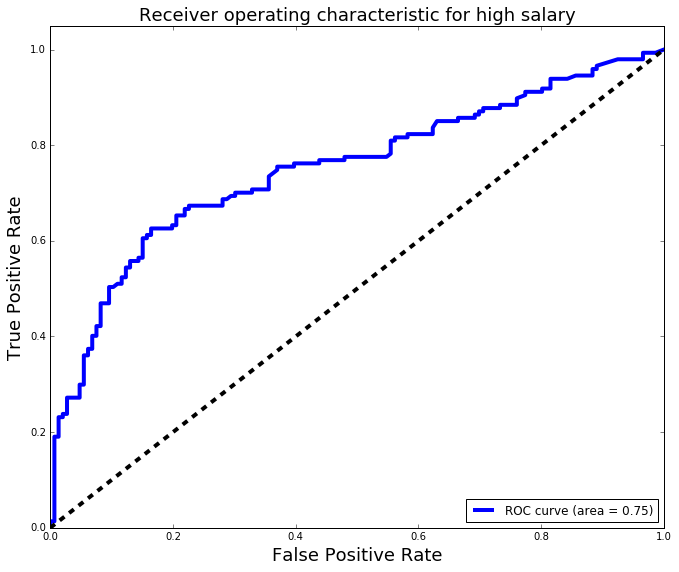

In [34]:
plot_roc(gbc_prob)

### SVM

In [35]:
# create dummies for categorical features

enc = OneHotEncoder(categorical_features=[0,1])
X = enc.fit_transform(X)

In [42]:
# tried linear kernel first, but the performance was worse

sv = svm.SVC(kernel='rbf')
sv_params = {'C': 10.**np.arange(-2,3), 'gamma': 10.**np.arange(-5, 2)}
gridsearch(sv, sv_params)

Best parameters:  {'C': 100.0, 'gamma': 0.01}
Best score:  0.706484641638


In [43]:
sv = svm.SVC(kernel='rbf', C=100, gamma=0.01, probability=True)

sv_pred, sv_prob = evaluation(sv)

Mean cross validation score:  0.706606353882


In [44]:
# SVM did a better job in identifying high salary jobs, but made more mistakes in misclassifying low salary jobs
confusions(sv_pred)

      pred high  pred low
high        108        39
low          47        99


In [45]:
print classification_report(y, sv_pred)

             precision    recall  f1-score   support

          0       0.72      0.68      0.70       146
          1       0.70      0.73      0.72       147

avg / total       0.71      0.71      0.71       293



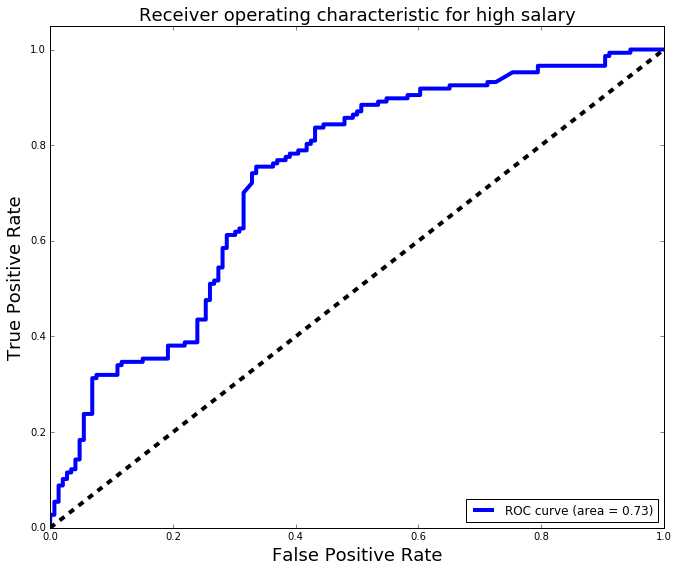

In [46]:
# SVM did poorly in the low range of false positive rate, which makes the model less useful
plot_roc(sv_prob)

Judging from the ROC curve, if we focus on controlling false positive rate, random forest (if control fpr<0.4) or gradient boosting (if control fpr<0.2) should be used.